<a href="https://colab.research.google.com/github/Tomershigani/LinkedIn-Income-Potential-Estimator-Lab-Project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import pyspark
from pyspark.sql.functions import regexp_replace, split ,  concat, col , concat_ws , sort_array , array , udf
from pyspark.sql.functions import lower, transform, regexp_extract , lit , when , desc ,expr
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer ,StopWordsRemover , PCA ,VectorAssembler
import numpy as np
from pyspark.sql.types import FloatType , ArrayType, StringType, MapType, StructType, StructField
from pyspark.ml.linalg import Vectors , VectorUDT
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

csv_file_path_glass_door_jobs = "/dbfs/FileStore/shared_uploads/tomershigani@campus.technion.ac.il/Glassdoor_salary_data_cleaned-4.csv"

csv_file_path_companies = "/dbfs/FileStore/shared_uploads/tomershigani@campus.technion.ac.il/segel_companies_merged_with_kaggle_jobs.csv"


glass_door_jobs = pd.read_csv(csv_file_path_glass_door_jobs)
glass_door_jobs = spark.createDataFrame(glass_door_jobs)

companies_merged = pd.read_csv(csv_file_path_companies)
companies_merged = spark.createDataFrame(companies_merged)
companies_merged = companies_merged.withColumnRenamed('company', 'Company Name')


# Extract the city part by splitting on comma and selecting the first part
glass_door_jobs = glass_door_jobs.withColumn("city", split(glass_door_jobs["Location"], ",")[0])

# Replace spaces with hyphens in the city names
glass_door_jobs = glass_door_jobs.withColumn("city", regexp_replace(glass_door_jobs["city"], " ", ""))

from pyspark.sql.functions import col, lower, regexp_replace, when

# Lowercase and remove spaces from company names in both DataFrames
glass_door_jobs = glass_door_jobs.withColumn("Company Name", regexp_replace(lower(col("Company Name")), " ", ""))
companies_merged = companies_merged.withColumn("Company Name", regexp_replace(lower(col("Company Name")), " ", ""))

# Select only the necessary columns from companies_merged
companies_merged_selected = companies_merged.select("Company Name", "about")

# Join the DataFrames on the lowercase, space-removed company names
joined_df = glass_door_jobs.join(companies_merged_selected, "Company Name", "left_outer")

# Concatenate the about section to the Job Description column
joined_df = joined_df.withColumn("Job Description", when(joined_df["about"].isNull(), joined_df["Job Description"]).otherwise(joined_df["Job Description"] + " " + joined_df["about"]))


# Drop the about column as it's no longer needed
joined_df = joined_df.drop("about")

# Show the resulting DataFrame
glass_door_jobs = joined_df

glass_door_jobs = glass_door_jobs.withColumn("Concatenated_Description",
                                             concat_ws(' ',
                                                       glass_door_jobs["Job Title"],
                                                       glass_door_jobs["Industry"],
                                                       glass_door_jobs["Job Description"]))



csv_file_path_indeed = "/dbfs/FileStore/shared_uploads/tomershigani@campus.technion.ac.il/min_max_avg_salaraies.csv"
indeed_jobs = pd.read_csv(csv_file_path_indeed)
indeed_jobs = spark.createDataFrame(indeed_jobs)

indeed_jobs = indeed_jobs.withColumnRenamed("Job Title", "Job Title Indeed")

# Perform the join
glass_door_jobs = glass_door_jobs.join(indeed_jobs, glass_door_jobs["Job Title"] == indeed_jobs["Job Title Indeed"], "left")


glass_door_jobs = glass_door_jobs.withColumn("Low", when(col("Low").isNull(), col("Salary Estimate")).otherwise(col("Low"))) \
                     .withColumn("Average", when(col("Average").isNull(), col("Salary Estimate")).otherwise(col("Average"))) \
                     .withColumn("High", when(col("High").isNull(), col("Salary Estimate")).otherwise(col("High")))


# display(glass_door_jobs)

# companies abouts:

cleaned_df = glass_door_jobs.na.drop(subset=["Concatenated_Description"])

# Tokenize the company_A_about
tokenizer = Tokenizer(inputCol="Concatenated_Description", outputCol="words_Job_Description")
tokenized_df = tokenizer.transform(cleaned_df)
transformed_df = tokenized_df

remover = StopWordsRemover(inputCol="words_Job_Description", outputCol="filtered_words_Job_Description")
transformed_df = remover.transform(transformed_df)


In [ ]:

glove_path = "dbfs:/FileStore/shared_uploads/tomershigani@campus.technion.ac.il/glove_6B_50d.txt"  # Update this path
glove_df = spark.read.text(glove_path)

def parse_glove_line(line):
    parts = line.value.split(" ")
    word = parts[0]
    vector = Vectors.dense([float(x) for x in parts[1:]])
    return (word, vector)

glove_rdd = glove_df.rdd.map(parse_glove_line)
glove_words_df = glove_rdd.toDF(["word", "vector"])


dimension = 50

# Convert the GloVe DataFrame to a Python dictionary
glove_dict = {row['word']: row['vector'] for row in glove_words_df.collect()}

# Broadcast the GloVe dictionary
bc_glove_dict = SparkContext.getOrCreate().broadcast(glove_dict)


# UDF to average word vectors for a phrase
def avg_word_vectors(words):
    vectors = [bc_glove_dict.value.get(word.lower(), Vectors.dense([0.0]*dimension)) for word in words]  # Ensure to lower() here if your dictionary keys are in lowercase
    if vectors:
        # Calculate the mean vector
        mean_vector = Vectors.dense([sum(x)/len(vectors) for x in zip(*vectors)])
        return mean_vector
    else:
        # Return a zero vector if no words are found
        return Vectors.dense([0.0]*dimension)

avg_word_vectors_udf = udf(avg_word_vectors, VectorUDT())

transformed_df = transformed_df.withColumn("city_words", split(lower(col("city")), " "))

# Apply the UDF on the array of words to get the job title vector

transformed_df = transformed_df.withColumn("city_vector", avg_word_vectors_udf(col("city_words")))

transformed_df = transformed_df.withColumn("filtered_words_Job_Description_glove", avg_word_vectors_udf(col("filtered_words_Job_Description")))

df_assembled =transformed_df
assembler = VectorAssembler(inputCols=["filtered_words_Job_Description_glove","city_vector"], outputCol="features")
transformed_df = assembler.transform(transformed_df)





K: 30, Cost: 2571.9703173054922, Silhouette Score: 0.4899994945023511
K: 31, Cost: 2522.381394910797, Silhouette Score: 0.5015686640914749
K: 32, Cost: 2461.1933806100865, Silhouette Score: 0.49600514032260296
K: 33, Cost: 2398.7687860946435, Silhouette Score: 0.4124541202285014
K: 34, Cost: 2267.4152421580256, Silhouette Score: 0.5427939472925345
K: 35, Cost: 2247.7430349527867, Silhouette Score: 0.5444169857253136
K: 36, Cost: 2301.6438583093445, Silhouette Score: 0.49543889541067104
K: 37, Cost: 2337.1997482246593, Silhouette Score: 0.49620305906097556
K: 38, Cost: 2293.104210071947, Silhouette Score: 0.47657513613818225
K: 39, Cost: 2233.4470133554755, Silhouette Score: 0.492844695468311
K: 40, Cost: 2202.754670612424, Silhouette Score: 0.4803326544338389
K: 41, Cost: 2068.944829570521, Silhouette Score: 0.4850896193045593
K: 42, Cost: 1958.1247738984175, Silhouette Score: 0.5085330129013695
K: 43, Cost: 1957.46689852482, Silhouette Score: 0.5276735751821812
K: 44, Cost: 1930.53622

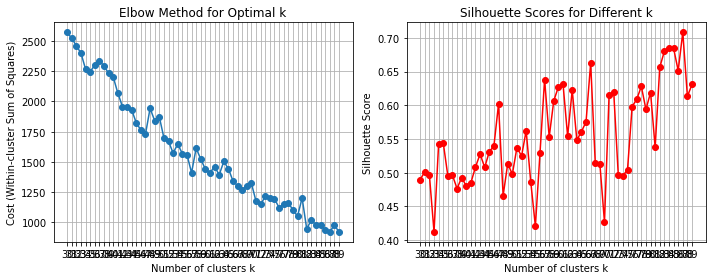

In [ ]:


# Define a UDF to convert array<float> to Vector type
array_to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())

df_vector = transformed_df

costs = []
silhouette_scores = []
k_range = range(30, 90, 1)  # Adjusted for demonstration; use a step for larger ranges

for k in k_range:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_vector)
    predictions = model.transform(df_vector)

    # This is the within-cluster sum of squared distances
    cost = model.summary.trainingCost
    costs.append(cost)

    # Compute Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    print(f"K: {k}, Cost: {cost}, Silhouette Score: {silhouette}")

# Plotting the elbow curve for Cost
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_range, costs, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Cost (Within-cluster Sum of Squares)')
plt.xticks(k_range)
plt.grid(True)

# Plotting the Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='red')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)

plt.tight_layout()
plt.show()


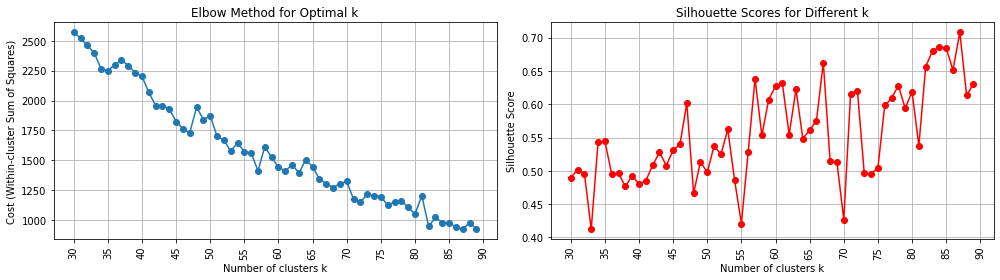

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming costs and silhouette_scores are defined
# Example: costs = [250 - i for i in range(50)]  # Replace with actual costs
# Example: silhouette_scores = [0.5 + i*0.005 for i in range(50)]  # Replace with actual scores

# Define the range of k
k_range = range(30, 90)

# Set the intervals for the x-axis ticks
tick_interval = 5
k_ticks = np.arange(min(k_range), max(k_range) + tick_interval, tick_interval)

# Plotting the elbow curve for Cost
plt.figure(figsize=(14, 4))  # Increased figure size for better clarity

plt.subplot(1, 2, 1)
plt.plot(k_range, costs, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Cost (Within-cluster Sum of Squares)')
plt.xticks(k_ticks, rotation=90)  # Set the x-axis ticks with the defined interval and rotation
plt.grid(True)

# Plotting the Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='red')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.xticks(k_ticks, rotation=90)  # Set the x-axis ticks with the defined interval and rotation
plt.grid(True)

plt.tight_layout()  # Adjust layout to fit the rotated x-axis labels
plt.show()


In [ ]:

df_vector = transformed_df
array_to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
costs = []
silhouette_scores = []

k=47
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_vector)
predictions = model.transform(df_vector)

# This is the within-cluster sum of squared distances
cost = model.summary.trainingCost
costs.append(cost)

# Compute Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
silhouette_scores.append(silhouette)
print(f"K: {k}, Cost: {cost}, Silhouette Score: {silhouette}")

display(predictions.groupBy("prediction").count().orderBy(desc("count")))


K: 47, Cost: 1729.4651765332144, Silhouette Score: 0.6016039375776633


prediction,count
16,105
35,60
13,55
2,53
1,49
19,45
0,40
36,29
6,28
26,27


/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field pcaFeatures. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


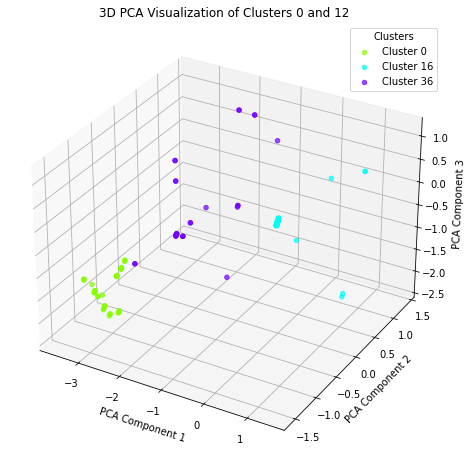

In [ ]:

# Adjust PCA to 3 components
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model_pca = pca.fit(predictions)

result = model_pca.transform(predictions).select("prediction", "pcaFeatures")
result_pandas = result.toPandas()

# Extracting the individual PCA components
result_pandas['pca_x'] = result_pandas['pcaFeatures'].apply(lambda x: x[0])
result_pandas['pca_y'] = result_pandas['pcaFeatures'].apply(lambda x: x[1])
result_pandas['pca_z'] = result_pandas['pcaFeatures'].apply(lambda x: x[2])

# Filter result_pandas for only clusters 0 and 12
filtered_data = result_pandas[result_pandas['prediction'].isin([0, 16, 36])]

# Unique clusters in the filtered data (should only be 0 and 12)
unique_clusters = filtered_data['prediction'].unique()

# Generate a color palette with enough colors for the filtered clusters
palette = sns.color_palette("hsv", len(unique_clusters))

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for filtered clusters
for cluster, color in zip(unique_clusters, palette):
    cluster_data = filtered_data[filtered_data['prediction'] == cluster]
    ax.scatter(
        cluster_data['pca_x'],
        cluster_data['pca_y'],
        cluster_data['pca_z'],
        color=color,
        alpha=0.7,
        label=f'Cluster {cluster}'
    )

# Customize the legend and labels
ax.legend(title="Clusters")
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA Visualization of Clusters 0 and 12')

# Show the plot
plt.show()


In [ ]:

user_experience_embedded = "dbfs:/FileStore/shared_uploads/bellaperel@campus.technion.ac.il/users-expirience-embedded.csv"

profiles = spark.read.parquet('/linkedin/people')
companies = spark.read.parquet('/linkedin/companies')

profiles = profiles.withColumn("descriptions", concat_ws(", ", "experience.description"))
profiles = profiles.withColumn("info", concat_ws(", ", "volunteer_experience.info"))
profiles = profiles.withColumn("concatenated_experience", concat(col("descriptions"),lit(" "), col("info"))) #concat


profiles = profiles.withColumn("degree", concat_ws(", ", "education.degree"))#.select("degree").show(truncate=False)
profiles = profiles.withColumn("field", concat_ws(", ", "education.field"))#.select("degree").show(truncate=False)
profiles = profiles.withColumn("concatenated_education", concat(col("degree"), lit(" "), col("field")))
profiles = profiles.withColumn("concatenated_column", concat(col("concatenated_experience"), lit(" "), col("concatenated_education")))


profiles = profiles.withColumn("сourses", concat_ws(", ", "сourses.title"))
profiles = profiles.withColumn("concatenated_column", concat(col("concatenated_column"),lit(" "),  col("сourses")))

profiles = profiles.withColumn("certifications_titles", concat_ws(", ", "certifications.title"))
profiles = profiles.withColumn("concatenated_column", concat(col("concatenated_column"),lit(" "),  col("certifications_titles")))

profiles = profiles.withColumn("current_company_position", concat_ws(": ", col("current_company.name"), lit(" "), col("position")))

def proccess_positions(x):
    x = regexp_extract(x, r"^[^-|]+", 0)  # Extract the substring before the first dash or pipe character
    x = regexp_extract(x, r"^[^\\(]+", 0)  # Extract the substring before the first opening parenthesis
    x = split(x, " at")[0]  # Extract the substring before the first occurrence of " at"
    return x

profiles = profiles.withColumn("current_company_position", proccess_positions(col("current_company_position")))
profiles = profiles.withColumn("Concatenated_Description", concat(col("concatenated_column"), lit(" "), col("certifications_titles")))
profiles = profiles.withColumn('origin', lit(1))

tokenizer = Tokenizer(inputCol="Concatenated_Description", outputCol="concatenated_column_tokenized")
tokenized_df = tokenizer.transform(profiles)

# Embedd city using Glove:
transformed_df_2 = tokenized_df
glove_path = "dbfs:/FileStore/shared_uploads/tomershigani@campus.technion.ac.il/glove_6B_50d.txt"  # Update this path
glove_df = spark.read.text(glove_path)

def parse_glove_line(line):
    parts = line.value.split(" ")
    word = parts[0]
    vector = Vectors.dense([float(x) for x in parts[1:]])
    return (word, vector)

glove_rdd = glove_df.rdd.map(parse_glove_line)
glove_words_df = glove_rdd.toDF(["word", "vector"])

dimension = 50

glove_dict = {row['word']: row['vector'] for row in glove_words_df.collect()}

# Broadcast the GloVe dictionary
bc_glove_dict = SparkContext.getOrCreate().broadcast(glove_dict)


# UDF to average word vectors for a phrase
def avg_word_vectors(words):
    vectors = [bc_glove_dict.value.get(word.lower(), Vectors.dense([0.0]*dimension)) for word in words]  # Ensure to lower() here if your dictionary keys are in lowercase
    if vectors:
        # Calculate the mean vector
        mean_vector = Vectors.dense([sum(x)/len(vectors) for x in zip(*vectors)])
        return mean_vector
    else:
        # Return a zero vector if no words are found
        return Vectors.dense([0.0]*dimension)

avg_word_vectors_udf = udf(avg_word_vectors, VectorUDT())

transformed_df_2 = transformed_df_2.withColumn("city_words", split(lower(col("city")), " "))
transformed_df_2 = transformed_df_2.withColumn("city_vector", avg_word_vectors_udf(col("city_words")))

from pyspark.sql import SparkSession
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="concatenated_column_tokenized", outputCol="filtered_words_Job_Description")

transformed_df_2 = remover.transform(transformed_df_2)

transformed_df_2 = transformed_df_2.withColumn("concatenated_column_output_features", avg_word_vectors_udf(col("filtered_words_Job_Description")))
assembler = VectorAssembler(inputCols=["concatenated_column_output_features", "city_vector"], outputCol="features_vector")
transformed_df_2 = assembler.transform(transformed_df_2)


In [ ]:

def record_vector(model,transformed_df_2):
    centroids = model.clusterCenters()  # This is a list of numpy arrays


    def euclidean_distance(v1, v2):
        return np.sqrt(np.sum((v1 - v2) ** 2))


    record_vector_full = transformed_df_2.limit(1)
    # Example: Selecting the first record's "features_vector"
    record_vector = transformed_df_2.select("features_vector").first()["features_vector"]

    # Convert the DenseVector to a numpy array for distance computation
    record_vector_np = np.array(record_vector)

    # Compute distances from this record to each centroid
    distances = [euclidean_distance(record_vector_np, np.array(centroid)) for centroid in centroids]

    # Get the index (and thus the cluster) of the closest centroid
    closest_cluster = np.argmin(distances)

    # Create a new DataFrame with the "prediction" column
    record_vector_full = record_vector_full.withColumn("prediction", lit(int(closest_cluster)))
    return record_vector_full

In [ ]:
# from pyspark.sql.functions import regexp_extract, col, expr

def get_similar_records(predictions,record_vector_full):
    # Define the DataFrame, assume df is your DataFrame
    df = predictions

    # Regular expression pattern to match numbers before 'K'
    # The pattern has two groups, one for each number in the salary range
    pattern = r"\$(\d+)K-\$(\d+)K"

    # Extract the lower and upper salary estimates
    df = df.withColumn("low_glassdoor", regexp_extract("Salary Estimate", pattern, 1).cast('integer') * 1000)
    df = df.withColumn("high_glassdoor", regexp_extract("Salary Estimate", pattern, 2).cast('integer') * 1000)
    df = df.withColumn("avg_glassdoor", expr("(low_glassdoor + high_glassdoor) / 2.0"))


    # Conditional replacement
    df = df.withColumn("Low", when(col("Low").contains("(Glassdoor est.)"), col("low_glassdoor")).otherwise(col("Low")))\
        .withColumn("Average", when(col("Average").contains("(Glassdoor est.)"), col("avg_glassdoor")).otherwise(col("Average")))\
        .withColumn("High", when(col("High").contains("(Glassdoor est.)"), col("high_glassdoor")).otherwise(col("High")))


    predictions = df

    cluster_df = record_vector_full

    # Extract the feature vector from the single record in cluster_df using first() instead of collect()
    given_record_feature_vector = cluster_df.select("features_vector").first()["features_vector"]

    # Broadcast the single record feature vector
    bc_given_record_feature_vector = spark.sparkContext.broadcast(given_record_feature_vector)

    # Define a UDF to compute the Euclidean distance
    @udf(FloatType())
    def euclidean_distance_udf(feature_vector):
        return float(np.sqrt(np.sum((np.array(feature_vector) - np.array(bc_given_record_feature_vector.value)) ** 2)))

    # Add a new column to `predictions` that contains the Euclidean distances
    predictions = predictions.withColumn("distance", euclidean_distance_udf(col("features")))

    # Filter for only those records in the same cluster as your given record
    given_record_cluster = cluster_df.select("prediction").first()["prediction"]
    # print(given_record_cluster)
    similar_records = predictions.where(f"prediction == {given_record_cluster}")
    return similar_records

In [ ]:

def salary_final(similar_records):
    # Ensure consistent indentation for all statements within the function
    similar_records = similar_records.dropDuplicates(["Company Name", "Job Title"])

    num_in_cluster = similar_records.count()

    if(num_in_cluster < 3):
        top_n = max(num_in_cluster, 3)
    else:
        top_n = 3
    # Get the closest records
    closest_records_df = similar_records.orderBy("distance").limit(top_n)
    # Calculate the sum of each column and convert to float

    sum_low_glassdoor = float(closest_records_df.agg(F.sum("low_glassdoor").alias("sum_low_glassdoor")).collect()[0]["sum_low_glassdoor"])
    sum_avg_glassdoor = float(closest_records_df.agg(F.sum("avg_glassdoor").alias("sum_avg_glassdoor")).collect()[0]["sum_avg_glassdoor"])
    sum_high_glassdoor = float(closest_records_df.agg(F.sum("high_glassdoor").alias("sum_high_glassdoor")).collect()[0]["sum_high_glassdoor"])

    # Get the number of rows
    num_rows = closest_records_df.count()

    # Calculate the final averages and convert to integer
    avg_Low_low_glassdoor = int(sum_low_glassdoor / num_rows)
    avg_Average_avg_glassdoor = int(sum_avg_glassdoor / num_rows)
    avg_High_high_glassdoor = int(sum_high_glassdoor / num_rows)

    # Output the results
    print(f"The minimum salary rate for your level of job experience in dollars per year is : {avg_Low_low_glassdoor}")
    print(f"The average salary rate for your level of job experience in dollars per year is: {avg_Average_avg_glassdoor}")
    print(f"The maximum salary rate for your level of job experience in dollars per year is: {avg_High_high_glassdoor}")

    selected_df = closest_records_df.select('Job Title', "Job Description", "Location")
    print("Examples of roles that align with your level of professional experience:")

    display(selected_df)
 # Assuming you're running this in a PySpark environment where display() might not be defined


##Try it by yourself
If you wish to explore further, you can experiment with other profiles from the LinkedIn dataset by entering the "id" of your desired user and trying it out yourself.



In [ ]:
filter_df = transformed_df_2.filter(col('id') == 'replace with your desired user id')
record_vector_full = record_vector(model,filter_df)
similar_records = get_similar_records(predictions,record_vector_full)
salary_final(similar_records)

##Example users:

Alicia Caputo describes herself as someone who provides insightful solutions through data, enhancing effectiveness and precision while minimizing time wastage. With nine years of experience, she has excelled in leading predictive analytics initiatives, merging business strategies with data science to unlock valuable insights. Consequently, based on her expertise and experience, our model has categorized her within a salary range consistent with roles requiring similar job descriptions and responsibilities.

In [ ]:
# Output the results
filter_df = transformed_df_2.filter(col('id') == 'alicia-caputo-06973310')
record_vector_full = record_vector(model,filter_df)
similar_records = get_similar_records(predictions,record_vector_full)
salary_final(similar_records)

The minimum salary rate for your level of job experience in dollars per year is : 100000
The average salary rate for your level of job experience in dollars per year is: 126666
The maximum salary rate for your level of job experience in dollars per year is: 153333
Examples of roles that align with your level of professional experience:


Job Title Job Description Location Program/Data Analyst Type of Requisition:

Regular

Clearance Level Must Currently Possess:

None

Clearance Level Must Be Able to Obtain:

None

Suitability:

Agency Specific

Public Trust/Other Required:

NACI (T1)

Job Family:

Data Analysis

Job Description:

The Program/Data Analyst supports the data collection and analysis efforts for monitoring the implementation of a government program with respect to the care and placement of participants in a network of grant funded care provider program.

Duties include:
Work with contractor and federal staff to enhance the collection and analysis of program data
Update and develop on site data collection tools and processes to yield statistically reliable and informative data and support field program assessments
Assist in identifying performance outcomes and indicators
Identify uniform data points for analysis
Conduct high-level data interpretation and analysis using a data analytics platform
Prepare written summaries and presentations that reflect the results of the data analysis and present findings to agency leadership
Provide ad-hoc data reporting as needed
Oversee the quality and the production of analytical reports, including Intakes and field reporting
Help train contractor and field staff on the use of data collection and analysis tools
Assist with projects that support the continual improvement of data analysis
Compile, analyze, and visualize data using a data visualization platform such as Tableau
Help build data repositories and databases using MS Access or other platforms
This position is based in Washington, DC and requires a Public Trust (or the ability to obtain it).

Education:

Requires BS/BA degree in a related field

Experience/Skills:
At least 5 years of experience with quantitative and qualitative data interpretation and analysis. 3 years with a Master’s degree.
Working knowledge of data visualization platforms (Tableau) and scripting languages (R)
Working familiarity with SQL and familiarity with relational databases
Advanced skills in Excel, Access, and VBA
Exceptional analytic skills
Strong attention to detail
Strong written and verbal communication skills
Experience working with immigrants, refugees, and underserved populations is preferred
#GDITpriority

Scheduled Weekly Hours:

40

Travel Required:

Less than 10%

Telecommuting Options:

Some Telecommuting Allowed

Work Location:

USA DC Washington

Additional Work Locations:

We are GDIT. The people supporting some of the most complex government, defense, and intelligence projects across the country. We deliver. Bringing the expertise needed to understand and advance critical missions. We transform. Shifting the ways clients invest in, integrate, and innovate technology solutions. We ensure today is safe and tomorrow is smarter. We are there. On the ground, beside our clients, in the lab, and everywhere in between. Offering the technology transformations, strategy, and mission services needed to get the job done.

GDIT is an Equal Opportunity/Affirmative Action employer. All qualified applicants will receive consideration for employment without regard to race, color, religion, sex, sexual orientation, gender identity, national origin, disability, or veteran status, or any other protected class. Washington, DC Associate Data Engineer About EAB

At EAB, our mission is to make education smarter and our communities stronger. We harness the collective power of 1,600+ schools, colleges, and universities to uncover and apply proven practices and transformative insights. And since complex problems require multifaceted solutions, we work with each school differently to apply these insights through a customized blend of research, technology, and services. From kindergarten to college and beyond, EAB partners with education leaders, practitioners, and staff to accelerate progress and drive results across three key areas: enrollment management, student success, and institutional o

Jason Vogel possesses extensive experience in software development, particularly in domains pertinent to investment services applications, business process management, and data-intensive systems. His expertise extends to areas such as data analytics, operations workflow enhancement, and the management of large-scale data-intensive systems.

In [ ]:
# Output the results
filter_df = transformed_df_2.filter(col('id') == 'jasonvogel')
record_vector_full = record_vector(model,filter_df)
similar_records = get_similar_records(predictions,record_vector_full)
salary_final(similar_records)

The minimum salary rate for your level of job experience in dollars per year is : 84666
The average salary rate for your level of job experience in dollars per year is: 116000
The maximum salary rate for your level of job experience in dollars per year is: 147333
Examples of roles that align with your level of professional experience:


Job Title Job Description Location Staff Data Engineer Sumo Logic: Staff Data Engineer


What we do:
We are a cloud-native SaaS machine data analytics platform, solving complex monitoring problems for DevOps, SecOps and ITOps teams. Customers love our product because it allows them to easily monitor and optimize their mission critical, large scale applications.

Massive Scale:
Our microservices architecture in AWS ingests hundreds of terabytes daily across many geographic regions. Millions of queries a day analyze hundreds of petabytes of data.

At Sumo Logic, we are building a data platform designed to power the analytics and investigations that are common in the Security Operation Centers of large enterprises. It is designed to accept hundreds of billions of events from security-relevant data sources (detection products, network sensors, log shippers, inventory systems) per day. It is cloud-native, with no plan to support an on-premise deployment. It is multi-tenant, and is designed to simultaneously process events from thousands of our customers. And, it is security-focused — it is designed to perform the kinds of stateful analyses that security analysts demand.

We are building this platform the way startups should — with ruthless prioritization, and with a live and demanding customer base. By joining as a Data Engineer, you have the opportunity to make our vision a reality, one feature at a time.

What You Will be Doing
Building, improving, maintaining, and scaling stream processing services.
Writing code. Reviewing code. Revising code.
Giving feedback on our standards. Holding your team mates to them.
Collaborating with teammates on major feature designs. Sometimes, you will own features, sometimes others will.
Helping our team grow organically. We value referrals. We value your feedback on candidates.
Who You Are
You are a software engineer. (We treat our data systems as software systems, and engineer them accordingly.)
You love working with data. (Small data. Big data. All the data.)
You are excited to optimize for events per second (not requests per second).
You have experience working with (or, at minimum a desire to work with) the technologies we use: Kafka, RocksDB, ElasticSearch, JanusGraph, Postgres, Spark, HBase.
You know (or want to write software in) Scala.
You love collecting data about your software as much as writing software that collects data. We measure everything. We make data-driven decisions.
You are collaborative. Nothing this hard can be accomplished by working alone. We work as a team.
Masters in Computer Science or equivalent experience (PHD in CS is a huge plus)
About Us

Mission:
Democratize machine data analytics through the Sumo Logic platform, bringing real-time data insights securely through the cloud.

Funding and Growth:
We have raised $345 million in funding to date, with the most recent round being May 2019. Investors include Battery Ventures, Greylock Partners, Sutter Hill Ventures, Accel Partners, Sequoia Capital, Sapphire Ventures and DFJ Growth. Our recurring revenue and customer base are growing steadily. We serve over 2,000 customers across the globe including Alaska Airlines, Anheuser Busch, Hootsuite, Hearst, Hudl, Major League Baseball, Marriott, Medidata, Sauce Labs, Samsung SmartThings, SPS Commerce, Twitter, Telstra, Toyota, Zuora and more. Austin, TX Geospatial Software Developer and Data Scientist Job Posting Title:

Geospatial Software Developer and Data Scientist

----

Hiring Department:

Applied Research Laboratories

----

Position Open To:

All Applicants

----

Weekly Scheduled Hours:

40

----

FLSA Status:

Exempt

----

Earliest Start Date:

Immediately

----

Position Duration:

Expected to Continue

----

Location:

PICKLE RESEARCH CAMPUS

----

Job Description:

Development and implementation of geospatial algorithms for a variety of remote sensing technologies and applications (airborne and space-based). Innovate machine learning and deep learning techniques f

As evident from the job description provided, the role necessitates experience both as a developer and in various aspects of data management and architecture, including data pipelines and automation, data analysis and quality assurance, as well as database maintenance and development. Additionally, effective collaboration and communication skills are highlighted, all of which closely align with the Jason Vogel's demonstrated expertise and experience.

In our model's setup, consider a user like Brad Polinko, who has a proven track record in data-driven decision making to enhance digital products. Brad's expertise lies in improving user experiences and managing digital project analysis, making him well-suited for roles that require sharp analysis of digital marketing performance

In [ ]:
filter_df = transformed_df_2.filter(col('id') == 'brad-polinko')
record_vector_full = record_vector(model,filter_df)
similar_records = get_similar_records(predictions,record_vector_full)
salary_final(similar_records)

The minimum salary rate for your level of job experience in dollars per year is : 60333
The average salary rate for your level of job experience in dollars per year is: 83666
The maximum salary rate for your level of job experience in dollars per year is: 107000
Examples of roles that align with your level of professional experience:


Job Title Job Description Location Digital Marketing & ECommerce Data Analyst Digital Marketing & eCommerce Data Analyst

IT BEGAN WITH A FLIP-FLOP. But not just any flip-flop. A sandal that revolutionized the industry, bringing biomechanical support to a quintessential summer staple. From these humble beginnings in Australia to the bustling San Francisco Bay Area, Vionic has grown from a fledgling business to a global footwear brand. We’re bringing together style and science and reimagining the look of supportive footwear.

Vionic has been named a 2018 Gallup Great Workplace Award Winner, and is the only company recognized in the fashion and retail sector. Vionic is one of just 39 companies globally to receive the prestigious award, which celebrates companies that achieve exceptional performance by creating a culture of high-reaching employee engagement. Gallup has rated Vionic among the top 2% of all companies based on "Employee Engagement” exceeding the national average by 65 percentage points. We are also officially certified and recognized as a Marin/Bay Area/California Green Business.

In a Nutshell

The Digital Marketing & Ecommerce Analyst will provide strategic and analytic support for the eCommerce and Digital Marketing teams. The eCommerce Data Analyst will implement and maintain the eCommerce Dashboard and build best in class digital marketing analytics. They will passionate about diving into Google Analytics to find new learnings and opportunities that will optimize the website and digital marketing performance. The ideal candidate has a demonstrated drive for working with data to creatively and tenaciously solve complex problems.

What You’ll Do:
You’ll be the “go to” person for analysis and data for the Digital Marketing & Ecommerce team.
You will set up custom reporting, funnels and analyze Google Analytics data to drive insightful learnings and testing opportunities to improve conversion rates and revenue.
You will use your knack for communicating complex data analysis into easy to understand bullets to explain the “story” behind the numbers and share actionable recommendations
You will partner with marketing and operations managers to design promo testing with a close to evaluate incremental return and margin impacts.
Perform ad-hoc data analysis and create custom reports to service the needs of business partners and leadership teams.
Create internal dashboards that automate key metrics and provide insights into performance within all aspects of eCommerce and digital marketing.
Manage voice of customer data to find new and better ways of collecting and communicating customer feedback.
Evaluate audience segmentation, creative and other marketing-related A/B tests and provide recommendations related to experiment prioritization.
Develop models that drive metrics and Ecommerce business toward improved operations and profitability – i.e. demand forecasting.
What You’ll Bring to the Team:
Bachelor’s degree from four-year college or university in a relevant subject (Math, Finance, Economics, Digital/marketing Analytics or related field);
Minimum of 1-3 years of full-time work experience in a highly analytical capacity, preferably an eCommerce environment.
2-3 years’ experience Advanced Google Analytics, certification highly preferred.
Heavy experience with e-Commerce platforms such as Magento or similar highly preferred
Can communicate complex data analysis in easy to understand bullets.
Experience with digital media management such as AdWords, Facebook ads manager, Criteo, Pinterest, and the like.
Experience with product purchasing analysis and audience segmentation.
Self-starter with problem-solving skills.
Experience with Microsoft Office Suite, with particularly advanced Excel skills (vlookups and pivot tables, other advanced formulas are a must.)
Experience in the development of Ecom dashboards to weekly channel performance.
How We Take Care of our People:

We offer a fun and dynamic workplace with a robust be